# Лабораторная работа № 2

## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML

### Часть 1

В данной части работы рассмотрены:
- подготовка признаков для рашения задачи **линейной регрессии**;
- создание и обучение модели линейной регрессии;
- оценка качества модели.ели.

### Запуск `Spark`-сессии

Подключаем необходимые библиотеки.

In [1]:
import os
import csv
import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml import Pipeline, Transformer, Estimator, Model
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer, StandardScaler,SQLTransformer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, when
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

Сформируем объект конфигурации для Apache Spark, указав необходимые параметры.

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    user_name = "dchel"
    
    conf = SparkConf()
    conf.setAppName("Lab 2")
    conf.setMaster("local[*]")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    # conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    # conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    # conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [3]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`.

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Загрузка датасета

In [5]:
df = spark.read.parquet("hdfs://namenode:9000/user/dchel/dchel_database/eCommerce_clear_data")

def print_df(df):
    return df.limit(10).toPandas()

In [6]:
print_df(df)

,event_type,product_id,brand,price,contains_appliances,contains_computers,contains_electronics,contains_kitchen,contains_smartphone
0,purchase,3601248,indesit,167.289993,True,False,False,True,False
1,view,8700613,sonar,20.590000,True,False,False,False,False
2,purchase,1005099,samsung,154.410004,False,False,True,False,True
3,cart,1801537,haier,360.079987,False,False,True,False,False
4,view,18300878,thule,110.360001,False,False,False,False,False
5,view,13200717,redford,253.550003,False,False,False,False,False
6,purchase,4804581,xiaomi,37.770000,False,False,True,False,False
7,view,28718040,millionaire,79.019997,False,False,False,False,False
8,view,2701697,bosch,523.020020,True,False,False,True,False
9,purchase,1004785,huawei,276.700012,False,False,True,False,True


Расшифровка столбцов
| Название столбца  | Расшифровка |
| ------------- | ------------- |
| asin | ID товара  |
|reviewerID  |ID рецензента  |
|reviewerName  |Имя рецензента  |
|reviewText  |Текст отзыва  |
|overall  |Общая оценка  (1.0-5.0)|
|summary  |Краткое описание  |
|unixReviewTime  |Время отзыва в Unix-времени  
| reviewTime | Время отзыва ||

Вспомним схему данных

In [7]:
df.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- contains_appliances: boolean (nullable = true)
 |-- contains_computers: boolean (nullable = true)
 |-- contains_electronics: boolean (nullable = true)
 |-- contains_kitchen: boolean (nullable = true)
 |-- contains_smartphone: boolean (nullable = true)



Вычислим количество строк в датафрейме.

In [8]:
df.count()

190323

### Постановка задачи GBT регрессии
Для датасета, заданного представленными колонками, требуется построить модель GBT регрессии 
для оценки рейтинга отзыва `(overall)` по всем остальным признакам.

Для оценки качества обучения следует использовать метрики RMSE и R².

### Подготовка и кодирование признаков

Отделим от датасета некоторую часть объёмом примерно 1000 строк, и сохраним её на диске как локальный csv-файл. Он понадобится в следующей лабораторной работе.

In [9]:
# Отделим от датасета некоторую часть объёмом примерно 1000 строк, и сохраним её на диске как локальный csv-файл
def save_sample_to_csv(data: DataFrame, file_path: str, 
                       sample_size: int = 1000) -> DataFrame:
    """
    Сохраняет первые `sample_size` строк из DataFrame в CSV-файл 
    на драйвере и возвращает DataFrame с оставшимися данными.

    Args:
        data (DataFrame): DataFrame, из которого нужно извлечь
            строки.
        file_path (str): Путь для сохранения CSV-файла.
        sample_size (int): Количество строк для сохранения
            (по умолчанию 1000).

    Returns:
        DataFrame: DataFrame с оставшимися данными.
    """
    # Определяем пропорции для разделения
    sample_fraction = sample_size / data.count()
    remaining_fraction = 1 - sample_fraction

    # Разделяем DataFrame на два непересекающихся набора данных
    sample_data, remaining_data = data.randomSplit(
        [sample_fraction, remaining_fraction]
    )

    # Сохраняем извлеченные строки в CSV-файл на драйвере
    try:
        with open(file_path, mode="w", newline="") as file:
            writer = csv.writer(file)

            # Записываем заголовок
            writer.writerow(data.columns)

            # Записываем строки
            for row in sample_data.take(sample_size):
                writer.writerow(row)
        print(f"Файл \"{file_path}\" с данными успешно создан.")

    except Exception as e:
        print(f"Ошибка при записи файла: {e}")

    return remaining_data

Определяем путь для сохранения csv-файла.

In [10]:
path = "streaming-data.csv"

df = save_sample_to_csv(data=df, file_path=path, sample_size=1000)

Файл "streaming-data.csv" с данными успешно создан.


Оцениваем, сколько строк в датасете осталось

In [11]:
df.count()

189316

Разделим датасет на обучающую и тестовую выборки.

In [12]:
train_df, test_df = df.randomSplit([0.8, 0.2])

In [13]:
print(f"Train dataset size: {train_df.count()}")
print(f"Test dataset size: {test_df.count()}")

Train dataset size: 151727
Test dataset size: 37589


#### Создаем бинарные признаки на основе цены

In [14]:
df = df.withColumn("is_expensive", when(col("price") > 200, 1).otherwise(0))
df = df.withColumn("is_budget", when(col("price") < 50, 1).otherwise(0))
df = df.withColumn("is_mid_range", when((col("price") >= 50) & (col("price") <= 200), 1).otherwise(0))

#### Признаки на основе категорий продуктов

In [15]:
df = df.withColumn("category_count", 
                   col("contains_appliances").cast("int") + 
                   col("contains_computers").cast("int") + 
                   col("contains_electronics").cast("int") + 
                   col("contains_kitchen").cast("int") + 
                   col("contains_smartphone").cast("int"))

#### Признаки на основе типа события

In [16]:
df = df.withColumn("is_purchase", when(col("event_type") == "purchase", 1).otherwise(0))
df = df.withColumn("is_view", when(col("event_type") == "view", 1).otherwise(0))
df = df.withColumn("is_cart", when(col("event_type") == "cart", 1).otherwise(0))

#### Группируем цены в диапазоны

In [17]:
df = df.withColumn("price_range", 
                   when(col("price") < 50, "budget")
                   .when(col("price") < 150, "affordable")
                   .when(col("price") < 300, "premium")
                   .otherwise("luxury"))

# Создаем числовое представление для price_range
df = df.withColumn("price_range_numeric",
                   when(col("price_range") == "budget", 1)
                   .when(col("price_range") == "affordable", 2)
                   .when(col("price_range") == "premium", 3)
                   .otherwise(4))

df.limit(10).toPandas()

,event_type,product_id,brand,price,contains_appliances,contains_computers,contains_electronics,contains_kitchen,contains_smartphone,is_expensive,is_budget,is_mid_range,category_count,is_purchase,is_view,is_cart,price_range,price_range_numeric
0,cart,1002042,samsung,77.139999,False,False,True,False,True,0,0,1,2,0,0,1,affordable,2
1,cart,1002524,apple,513.450012,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
2,cart,1002524,apple,513.469971,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
3,cart,1002524,apple,531.409973,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
4,cart,1002524,apple,533.260010,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
5,cart,1002524,apple,540.270020,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
6,cart,1002536,apple,576.570007,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
7,cart,1002542,apple,488.790009,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
8,cart,1002544,apple,460.070007,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4
9,cart,1002544,apple,460.309998,False,False,True,False,True,1,0,0,2,0,0,1,luxury,4


Идентификатор product_id не оказывают влияния на оценку отзыва. Использовать их в модели нет смысла.

Остальные признаки сгруппируем по их типу:

* **Категориальные признаки**: пока отсутствуют в исходных данных
* **Бинарные признаки**: создадим из текстовых данных
* **Количественные признаки**: временные метки и производные от текста
* **Текстовые признаки**: преобразуем в числовые (длина текста)

In [18]:
# Обновим датафреймы train и test с новыми признаками
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(train_df.count())
print(test_df.count())

151687
37629


In [19]:
train_df.groupBy("price_range_numeric").count().show()
train_df.groupBy("event_type").count().show()
train_df.groupBy("price_range").count().show()

+-------------------+-----+
|price_range_numeric|count|
+-------------------+-----+
|                  1|36324|
|                  3|35631|
|                  4|26427|
|                  2|53305|
+-------------------+-----+

+----------+------+
|event_type| count|
+----------+------+
|  purchase| 26143|
|      view|110475|
|      cart| 15069|
+----------+------+

+-----------+-----+
|price_range|count|
+-----------+-----+
|     luxury|26427|
|     budget|36324|
| affordable|53305|
|    premium|35631|
+-----------+-----+



In [20]:
# Определим группы признаков для модели
binary_features = [
    "is_expensive", 
    "is_budget", 
    "is_mid_range", 
    "is_purchase", 
    "is_view", 
    "is_cart",
    "contains_appliances",
    "contains_computers",
    "contains_electronics",
    "contains_kitchen",
    "contains_smartphone"
]

numeric_features = [
    "price",
    "category_count"
]

categorical_features = ["event_type"]

# Целевая переменная
label_col = "price_range_numeric"

print("Категориальные признаки:", categorical_features)
print("Бинарные признаки:", binary_features)
print("Числовые признаки:", numeric_features)
print("Целевая переменная:", label_col)

Категориальные признаки: ['event_type']
Бинарные признаки: ['is_expensive', 'is_budget', 'is_mid_range', 'is_purchase', 'is_view', 'is_cart', 'contains_appliances', 'contains_computers', 'contains_electronics', 'contains_kitchen', 'contains_smartphone']
Числовые признаки: ['price', 'category_count']
Целевая переменная: price_range_numeric


Отсутсвие категориальных признаков никак не помешает LogisticRegressor, поскольку данная модель отличнно работает с только с числовыми признаками и изначально разработана для работы с ними.

Создадим конвейер обработки данных, включающий модель LogisticRegressor

In [21]:
def create_lr_pipeline(categorical_features: list[str], numeric_features: list[str], 
                       binary_features: list[str], label_col: str) -> Pipeline:
    
    stages = []
    
    # Обработка категориальных признаков
    if categorical_features:
        indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
        string_indexer = StringIndexer(inputCols=categorical_features,
                                      outputCols=indexed_categorical_features,
                                      handleInvalid="keep")
        stages.append(string_indexer)

        onehot_categorical_features = [f"{feature}_encoded" for feature in categorical_features]
        onehot_encoder = OneHotEncoder(
            inputCols=indexed_categorical_features,
            outputCols=onehot_categorical_features,
            dropLast=True
        )
        stages.append(onehot_encoder)

        
    
    # Собираем числовые признаки в вектор
    vector_num_assembler = VectorAssembler(inputCols=numeric_features,
                                          outputCol="numeric_vector")
    stages.append(vector_num_assembler)
    
    # Масштабируем числовые признаки (ВАЖНО для LogisticRegression)
    numeric_scaler = StandardScaler(inputCol="numeric_vector",
                                   outputCol="numeric_vector_scaled",
                                   withStd=True,
                                   withMean=True)
    stages.append(numeric_scaler)
    
    # Собираем все features в финальный вектор
    feature_cols = ["numeric_vector_scaled"] + binary_features
    if categorical_features:
        feature_cols.extend(onehot_categorical_features)
    
    vector_all_assembler = VectorAssembler(inputCols=feature_cols,
                                          outputCol="features")
    stages.append(vector_all_assembler)
    
    # Создаем модель LogisticRegression
    lr = LogisticRegression(featuresCol="features",
                           labelCol=label_col,
                           predictionCol="prediction",
                           rawPredictionCol="rawPrediction",
                           probabilityCol="probability",
                           maxIter=100,
                           regParam=0.01,
                           elasticNetParam=0.0,
                           family="multinomial",
                           standardization=False)
    stages.append(lr)
    
    # Создаем конвейер
    pipeline = Pipeline(stages=stages)
    
    return pipeline

In [22]:
pipeline = create_lr_pipeline(categorical_features=categorical_features,
                              numeric_features=numeric_features,
                              binary_features=binary_features,
                              label_col=label_col)
print("Конвейер успешно создан!")

Конвейер успешно создан!


### Обучение модели

Выполним **подбор гиперпараметров** модели LogisticRegressor с помощью кросс-валидации на сетке

Создаем сетку параметров для кросс-валидации, получив объект `LogisticRegressor` из конвейера

In [23]:
# param_grid = ParamGridBuilder() \
#     .addGrid(pipeline.getStages()[-1].maxDepth, [3, 5]) \
#     .addGrid(pipeline.getStages()[-1].maxIter, [50]) \
#     .addGrid(pipeline.getStages()[-1].stepSize, [0.1]) \
#     .build()

lr_model = pipeline.getStages()[-1]

param_grid = ParamGridBuilder() \
    .addGrid(lr_model.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_model.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr_model.maxIter, [10, 100]) \
    .build()

Создаем экземпляр `RegressionEvaluator` для оценки модели

In [24]:
cv_evaluator = MulticlassClassificationEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="accuracy"
)

Создаем объект `CrossValidator`

In [25]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=2,  
                                 parallelism=4)  

Обучаем модель конвейера с использованием кросс-валидации.

In [26]:
print("Начинаем обучение модели LogisticRegressor с кросс-валидацией...")
lr_model = cross_validator.fit(train_df)
print("Обучение завершено!")

Начинаем обучение модели LogisticRegressor с кросс-валидацией...
Обучение завершено!


Выведем параметры **лучшей** модели, определенной в ходе кросс-валидации.

In [27]:
def get_best_lr_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel для LogisticRegression.

    Args:
        cv_model (CrossValidatorModel): Объект CrossValidatorModel, 
            содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели LogisticRegression.
    """
    best_model = cv_model.bestModel
    lr_model = best_model.stages[-1]
    
    best_params = {
        "regParam": lr_model.getRegParam(),
        "elasticNetParam": lr_model.getElasticNetParam(),
        "maxIter": lr_model.getMaxIter(),
        "tol": lr_model.getTol(),
        "fitIntercept": lr_model.getFitIntercept()
    }
    
    # Добавляем family, если доступно
    try:
        best_params["family"] = lr_model.getFamily()
    except:
        best_params["family"] = "multinomial"  # значение по умолчанию
    
    # Добавляем информацию о количестве классов
    try:
        best_params["numClasses"] = lr_model.numClasses
        best_params["numFeatures"] = lr_model.numFeatures
    except:
        pass
        
    return best_params

In [28]:
print("Параметры лучшей модели LogisticRegressor:")
for key, value in get_best_lr_params(cv_model=lr_model).items():
    print(f"{key}: {value}")

Параметры лучшей модели LogisticRegressor:
regParam: 0.01
elasticNetParam: 1.0
maxIter: 100
tol: 1e-06
fitIntercept: True
family: multinomial
numClasses: 5
numFeatures: 16


### Анализ процесса обучения

In [29]:
# Получаем датасет предсказаний
test_df_predictions = lr_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove(label_col)
right_columns_order.append(label_col)

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.limit(10).toPandas()

,event_type,product_id,brand,price,contains_appliances,contains_computers,contains_electronics,contains_kitchen,contains_smartphone,is_expensive,...,price_range,event_type_index,event_type_encoded,numeric_vector,numeric_vector_scaled,features,rawPrediction,probability,prediction,price_range_numeric
0,cart,1002524,apple,513.469971,False,False,True,False,True,1,...,luxury,2.0,"(0.0, 0.0, 1.0)","[513.469970703125, 2.0]","[2.45721677634597, 1.360615646227009]","(2.45721677634597, 1.360615646227009, 1.0, 0.0...","[-7.775730528403004, -1.3431555825940165, -8.7...","[2.2120077377337037e-09, 1.3753665103096971e-0...",4.0,4
1,cart,1002536,apple,576.570007,False,False,True,False,True,1,...,luxury,2.0,"(0.0, 0.0, 1.0)","[576.5700073242188, 2.0]","[2.9002770605119244, 1.360615646227009]","(2.9002770605119244, 1.360615646227009, 1.0, 0...","[-7.775730528403004, -1.8711157340486069, -10....","[2.3239024767091932e-10, 8.522353055429469e-08...",4.0,4
2,cart,1002544,apple,460.070007,False,False,True,False,True,1,...,luxury,2.0,"(0.0, 0.0, 1.0)","[460.07000732421875, 2.0]","[2.082266075585193, 1.360615646227009]","(2.082266075585193, 1.360615646227009, 1.0, 0....","[-7.775730528403004, -0.8963562737046726, -7.0...","[1.4826801049642227e-08, 1.4411916521087578e-0...",4.0,4
3,cart,1002629,apple,358.309998,False,False,True,False,True,1,...,luxury,2.0,"(0.0, 0.0, 1.0)","[358.30999755859375, 2.0]","[1.3677527209540112, 1.360615646227009]","(1.3677527209540112, 1.360615646227009, 1.0, 0...","[-7.775730528403004, -0.04492681272841481, -3....","[4.753600707792702e-07, 0.0010826001763988625,...",4.0,4
4,cart,1003114,sony,139.259995,False,False,True,False,True,0,...,affordable,2.0,"(0.0, 0.0, 1.0)","[139.25999450683594, 2.0]","[-0.17031859874188499, 1.360615646227009]","(-0.17031859874188499, 1.360615646227009, 0.0,...","[-7.775730528403004, 1.7878720092721736, 5.165...","[1.5445788912639905e-06, 0.021990236724405865,...",2.0,2
5,cart,1003304,apple,578.520020,False,False,True,False,True,1,...,luxury,2.0,"(0.0, 0.0, 1.0)","[578.52001953125, 2.0]","[2.9139691755856822, 1.360615646227009]","(2.9139691755856822, 1.360615646227009, 1.0, 0...","[-7.775730528403004, -1.887431552474271, -10.7...","[2.1675450143116713e-10, 7.820308369706738e-08...",4.0,4
6,cart,1003306,apple,583.169983,False,False,True,False,True,1,...,luxury,2.0,"(0.0, 0.0, 1.0)","[583.1699829101562, 2.0]","[2.946619142310595, 1.360615646227009]","(2.946619142310595, 1.360615646227009, 1.0, 0....","[-7.775730528403004, -1.9263379541381482, -10....","[1.8358375386343298e-10, 6.370788147658724e-08...",4.0,4
7,cart,1003439,gionee,74.650002,False,False,True,False,True,0,...,affordable,2.0,"(0.0, 0.0, 1.0)","[74.6500015258789, 2.0]","[-0.6239811222994974, 1.360615646227009]","(-0.6239811222994974, 1.360615646227009, 0.0, ...","[-7.775730528403004, 2.3284660169197533, 7.159...","[3.051692981111002e-07, 0.007459979645617333, ...",2.0,2
8,cart,1004059,xiaomi,378.130005,False,False,True,False,True,1,...,luxury,2.0,"(0.0, 0.0, 1.0)","[378.1300048828125, 2.0]","[1.5069199631217296, 1.360615646227009]","(1.5069199631217296, 1.360615646227009, 1.0, 0...","[-7.775730528403004, -0.21076148777878623, -4....","[2.539301132163535e-07, 0.0004899350571948088,...",4.0,4
9,cart,1004060,xiaomi,358.279999,False,False,True,False,True,1,...,luxury,2.0,"(0.0, 0.0, 1.0)","[358.2799987792969, 2.0]","[1.367542082919683, 1.360615646227009]","(1.367542082919683, 1.360615646227009, 1.0, 0....","[-7.775730528403004, -0.04467581192224812, -3....","[4.757928072442117e-07, 0.0010838577192386547,...",4.0,4


In [30]:
def evaluate_model(data: DataFrame, 
                   label_col: str) -> dict[str, float]:
    """
    Оценивает модель с использованием метрик точности, полноты и F1-score.

    Args:
        data: DataFrame, содержащий предсказания и фактические метки.
        label_col: Название колонки с меткой.

    Returns:
        dict[str, float]: Словарь с метриками точности, полноты и F1-score.
    """
    # # Вычисляем TP, FP, FN
    # tp = data.filter((F.col(label_col) == 1) &
    #                  (F.col("prediction") == 1)).count()
    # fp = data.filter((F.col(label_col) == 0) &
    #                  (F.col("prediction") == 1)).count()
    # fn = data.filter((F.col(label_col) == 1) &
    #                  (F.col("prediction") == 0)).count()

    # # Вычисляем метрики
    # precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # f1 = (2 * (precision * recall) / (precision + recall)
    #     if (precision + recall) > 0 else 0)

    # # Возвращаем словарь с метриками
    # return {
    #     "precision": precision,
    #     "recall": recall,
    #     "f1": f1
    # }

    metrics = {}

    prediction_col="prediction"
    
    evaluators = {
        "accuracy": MulticlassClassificationEvaluator(
            labelCol=label_col,
            predictionCol=prediction_col,
            metricName="accuracy"
        ),
        "weightedPrecision": MulticlassClassificationEvaluator(
            labelCol=label_col,
            predictionCol=prediction_col,
            metricName="weightedPrecision"
        ),
        "weightedRecall": MulticlassClassificationEvaluator(
            labelCol=label_col,
            predictionCol=prediction_col,
            metricName="weightedRecall"
        ),
        "f1": MulticlassClassificationEvaluator(
            labelCol=label_col,
            predictionCol=prediction_col,
            metricName="f1"
        )
    }
    
    for metric_name, evaluator in evaluators.items():
        try:
            metrics[metric_name] = float(evaluator.evaluate(data))
        except Exception as e:
            metrics[metric_name] = None

    return metrics

In [31]:
metrics = evaluate_model(test_df_predictions, label_col)
print(f"Test Metrics: {metrics}")
train_df_predictions = lr_model.transform(train_df)
metrics = evaluate_model(train_df_predictions, label_col)
print(f"Train Metrics: {metrics}")

Test Metrics: {'accuracy': 0.9677376491535784, 'weightedPrecision': 0.9691029432450163, 'weightedRecall': 0.9677376491535784, 'f1': 0.9674194453559453}
Train Metrics: {'accuracy': 0.9679273767692683, 'weightedPrecision': 0.969223627470349, 'weightedRecall': 0.9679273767692682, 'f1': 0.96761806613029}


In [32]:
def plot_lr_training_metrics(cv_model, test_data, label_col="label"):
    """
    Упрощенная версия для мультиклассовой классификации.
    """
    # Делаем предсказания
    test_predictions = cv_model.transform(test_data)
    
    # Вычисляем accuracy и F1
    evaluator_accuracy = MulticlassClassificationEvaluator(
        labelCol=label_col, 
        predictionCol="prediction", 
        metricName="accuracy"
    )
    
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol=label_col, 
        predictionCol="prediction", 
        metricName="f1"
    )
    
    test_accuracy = evaluator_accuracy.evaluate(test_predictions)
    test_f1 = evaluator_f1.evaluate(test_predictions)
    
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    
    # Матрица ошибок
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    y_true = test_predictions.select(label_col).rdd.flatMap(lambda x: x).collect()
    y_pred = test_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    
    cm = confusion_matrix(y_true, y_pred)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Матрица ошибок
    im = ax1.imshow(cm, cmap='Blues')
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    ax1.set_title(f'Матрица ошибок: {test_accuracy:.4f}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    # Диагональные элементы (правильные предсказания)
    ax2.bar(range(len(cm)), [cm[i, i] for i in range(len(cm))])
    ax2.set_title('Правильные предсказания по классам')
    ax2.set_xlabel('Класс')
    ax2.set_ylabel('Количество')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return test_predictions

Accuracy: 0.9677
F1-Score: 0.9674


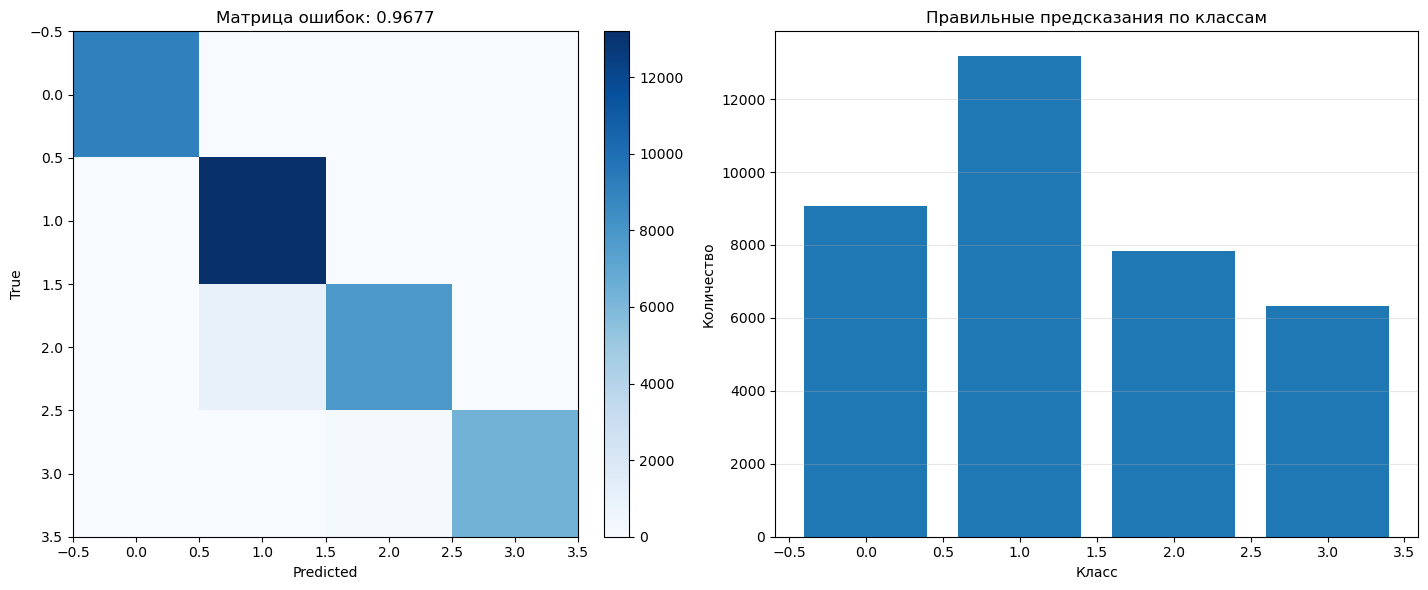

DataFrame[event_type: string, product_id: int, brand: string, price: double, contains_appliances: boolean, contains_computers: boolean, contains_electronics: boolean, contains_kitchen: boolean, contains_smartphone: boolean, is_expensive: int, is_budget: int, is_mid_range: int, category_count: int, is_purchase: int, is_view: int, is_cart: int, price_range: string, price_range_numeric: int, event_type_index: double, event_type_encoded: vector, numeric_vector: vector, numeric_vector_scaled: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [33]:
plot_lr_training_metrics(lr_model, test_df, label_col)

### Сохранение модели

In [34]:
# Путь модели
model_path = f"lr-movies-model"

database_name = "dchel_database"
model_table_name = "lr_eCommerce_lr_model"

output_path = f"hdfs://namenode:9000/user/dchel/{database_name}/{model_path}"

# Сохраняем модель конвейера в HDFS
try:
    lr_model.bestModel.save(output_path)
    print(f"Модель LogisticRegressor успешно сохранена в \"{output_path}\"")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Ошибка при сохранении модели: An error occurred while calling o29994.save.
: java.io.IOException: Path hdfs://namenode:9000/user/dchel/dchel_database/lr-movies-model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.

In [35]:
spark.stop()